# 🌐 GNN for Node-Level Regression: Predicting Sine Waves

**Author:** Loïc Bachelot  
**Goal:** This notebook demonstrates how to use a GNN to predict 1D sine wave signals at each node of a synthetic graph.

---

## 📘 Overview

Graphs provide a natural framework to represent structured spatial relationships, like seismic stations or sensor networks.

In this notebook:
- Each node in the graph has spatial coordinates and a local signal (a sine wave).
- The task is to predict the full sine wave **at each node** based on the graph structure and node features.
- We use **GNNs** with message passing to exploit the spatial relationships between nodes.

We will:
- Generate synthetic 3D graphs with signals delayed based on spatial distance
- Define a GNN model for **node-level regression**
- Train the model to recover sine signals from noisy observations
- Visualize and evaluate the predictions at the node level

This setup introduces important concepts for modeling spatiotemporal data with graph-based deep learning!


## 📦 Imports and Setup

We first import the core libraries needed for:

- Graph data manipulation (`torch_geometric`)
- Deep learning (`torch`)
- Numerical operations (`numpy`)
- Visualization (`matplotlib`)

This setup ensures we have all the tools needed for dataset generation, model training, and evaluation.

In [1]:
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

2.6.0+cu124
2.6.1


In [2]:
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pickle
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch
import torch_geometric
from torch_geometric.transforms import KNNGraph
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear, Parameter, LeakyReLU, Conv2d, MaxPool1d, Conv1d
from torch_geometric.nn import GCNConv, MessagePassing, MLP, GATv2Conv  
from scipy.spatial import distance
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm
import time
import random
import os

### 🖼️ Visualization Helper Functions

We define two visualization utilities to better explore and understand the synthetic graphs.

---

### 🌐 1. `visualize_graph_torch()`

Plots the graph structure with flexible coloring options.

- **Edges** are plotted as light gray lines connecting nodes.
- **Nodes** are colored based on:
  - An internal attribute (e.g., `"signal"`, `"attention"`)
  - Or external per-node values (e.g., prediction errors).
- **Origin** (hidden point that controls the delay) is plotted as a **red cross (×)** if available.
- A colorbar is automatically generated to aid interpretation.

✅ Useful for visualizing spatial structure, feature distributions, and model errors.

---

### 📈 2. `plot_signals_subplots_by_distance()`

Visualizes the individual node signals sorted by distance from the hidden origin.

- **One subplot per node**: each shows the sine waveform observed at that node.
- Nodes are **sorted** by increasing distance to the origin.
- A **vertical red dashed line** marks the expected arrival time of the sine wave based on distance and velocity.

✅ Useful for understanding how distance delays the waveform across the graph.

---


In [4]:
def visualize_graph_torch(g, color=None, node_values=None, cmap="viridis", ax=None, title=None):
    """
    Visualize a graph structure with nodes colored by a selected attribute or external values.

    Args:
        g (Data): PyG graph object with at least 'edge_index' and 'pos'. May also have 'origin'.
        color (str, optional): Node attribute key inside `g` to color nodes (e.g., 'signal').
        node_values (Tensor, optional): External array of node values for coloring (overrides `color` if provided).
        cmap (str, optional): Matplotlib colormap name for node coloring.
        ax (matplotlib axis, optional): Axis to plot into (if None, create a new figure).
        title (str, optional): Title for the plot.

    Behavior:
        - Nodes are colored based on either an internal attribute or external values.
        - Edges are drawn as light gray lines between connected nodes.
        - A colorbar is added automatically when node coloring is used.
        - If `origin` is present, it is shown as a red "x" marker.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # --- Draw edges ---
    for edge in g.edge_index.T:
        ax.plot(
            [g.pos[edge[0]][0], g.pos[edge[1]][0]],
            [g.pos[edge[0]][1], g.pos[edge[1]][1]],
            color='lightgray', linewidth=0.8, zorder=0
        )

    # --- Determine node coloring ---
    if node_values is not None:
        node_colors = node_values
    elif color is not None:
        node_colors = g[color][:, 0].cpu().numpy()
    else:
        node_colors = "blue"  # fallback color

    # --- Draw nodes ---
    scatter = ax.scatter(
        g.pos[:, 0].cpu(),
        g.pos[:, 1].cpu(),
        c=node_colors,
        cmap=cmap,
        s=150,
        edgecolors='black'
    )

    # --- Plot origin if available ---
    if hasattr(g, 'origin'):
        origin = g.origin.cpu().numpy()
        ax.plot(origin[0], origin[1], 'rx', markersize=12, markeredgewidth=3, label="Origin")
        ax.legend(loc="upper right")

    # --- Add colorbar if appropriate ---
    if node_values is not None or color is not None:
        plt.colorbar(scatter, ax=ax, label="Node Value")

    if title:
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, linestyle="--", alpha=0.5)

    if ax is None:
        plt.show()



def plot_signals_subplots_by_distance(data, velocity=0.25, sampling_rate=1.0, title="Signals by distance to origin"):
    """
    Plot each node's signal in its own subplot, ordered by distance to the hidden origin.

    Args:
        data (Data): PyG graph object containing:
            - pos: [num_nodes, 2] node spatial coordinates
            - signal: [num_nodes, signal_size] node waveforms
            - origin: [2] hidden origin point (required to compute distance)
        velocity (float): Wave propagation speed (units per second).
        sampling_rate (float): Sampling rate in Hz (samples per second).
        title (str): Figure title.

    Behavior:
        - Sorts nodes by their distance to the origin.
        - Plots each node's signal in a separate subplot.
        - Marks the expected arrival sample with a red vertical line.
    """
    pos = data.pos.cpu().numpy()
    signals = data.signal.cpu().numpy()
    origin = data.origin.squeeze().cpu().numpy()

    num_nodes = pos.shape[0]

    # Compute distances from origin and convert to sample index
    distances = np.array([distance.euclidean(origin, pos[i].tolist()) for i in range(num_nodes)])
    arrival_samples = (distances / velocity * sampling_rate).astype(int)
    sort_idx = np.argsort(distances)

    # Plot one subplot per station
    fig, axs = plt.subplots(num_nodes, 1, figsize=(10, 2 * num_nodes), sharex=True)
    for i, idx in enumerate(sort_idx):
        ax = axs[i]
        signal = signals[idx]

        ax.plot(np.arange(len(signal)), signal, color='black', linewidth=1)
        ax.axvline(arrival_samples[idx], color='red', linestyle='--', linewidth=1, label='arrival')
        ax.set_ylabel(f"{distances[idx]:.2f}", rotation=0, labelpad=25)
        ax.grid(True, linestyle='--', alpha=0.3)

    axs[-1].set_xlabel("Time (samples)")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## 🧹 Synthetic Dataset Creation

We create a synthetic graph dataset where each node has:
- Random 2D spatial coordinates
- A **sine wave** signal, delayed according to its distance from a hidden origin point

The task is to predict the correct sine signal at each node, using the spatial structure and nearby signals as context.

---

### 🛠️ Components:

1. **`add_edge_weight(g)`**  
   A utility function that computes edge weights based on inverse spatial distance, helping GNN layers better prioritize closer nodes.

2. **`SinDataset` Class**  
   A PyTorch Geometric `InMemoryDataset` that:
   - Generates random graphs
   - Assigns sine signals to nodes with distance-based delays
   - Saves origin coordinate of signal
   - Optionally applies transformations like edge construction

This synthetic setup allows us to benchmark node-level regression performance.


In [5]:
def add_edge_weight(g):
    """
    Compute edge features as (dx, dy) vectors between connected nodes.
    """
    edge_attrs = []

    for edge in g.edge_index.T:
        src = g.pos[edge[0]]
        tgt = g.pos[edge[1]]
        delta = tgt - src  # (dx, dy)
        edge_attrs.append(delta)

    # Stack into [num_edges, 2] tensor
    g.edge_attr = torch.stack(edge_attrs, dim=0).type(torch.float32)
    return g


class SinDataset(InMemoryDataset):
    """
    Synthetic dataset for node-level sine wave reconstruction,
    using a **fixed set of node positions ("stations")** across all graphs.

    Each graph contains:
    - Same station layout (pos)
    - Different random hidden origin
    - Signals delayed based on distance to origin
    """

    def __init__(self, root, transform=None, pre_transform=None, nb_graph=10, nb_stations=15):
        self.nb_graph = nb_graph
        self.nb_stations = nb_stations

        # Generate fixed station positions once
        self.node_positions = torch.tensor(
            np.random.uniform(0, 6, size=(self.nb_stations, 2)),
            dtype=torch.float
        )
        super(SinDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        # No external raw files
        return 0

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        data_list = []

        # Dataset parameters
        frequency = 1.0        # Hz
        velocity = 0.25         # wave speed
        sampling_rate = 1.0    # Hz
        noise_std = 0.05        # Gaussian noise level

        # Base sine wave used in signal synthesis
        base_sine_wave = np.sin(np.arange(SIGNAL_SIZE))

        for _ in range(self.nb_graph):
            pos = self.node_positions

            # Random hidden origin point
            origin = np.random.randint(0, 6, size=2)
            origin_tensor = torch.tensor(origin, dtype=torch.float)

            signal_list = []
            for i in range(self.nb_stations):
                dist = distance.euclidean(origin, pos[i].tolist())
                delay = dist / velocity
                delay_samples = int(delay * sampling_rate)

                # Start with noise
                waveform = np.random.normal(0, noise_std, size=SIGNAL_SIZE)

                # Add delayed sine wave if within bounds
                if delay_samples < SIGNAL_SIZE:
                    insert_length = SIGNAL_SIZE - delay_samples
                    waveform[delay_samples:] += base_sine_wave[:insert_length]

                signal_list.append(waveform)

            signal = torch.tensor(np.array(signal_list), dtype=torch.float32).reshape(self.nb_stations, SIGNAL_SIZE)
            g = Data(pos=pos, signal=signal, origin=origin_tensor)  # y shape: (1, 2)
            data_list.append(g)
            
        # Apply preprocessing transformations if specified
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            data_list = [add_edge_weight(data) for data in data_list]

        # Save processed graphs
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
# Parameters
SIGNAL_SIZE = 25
NB_GRAPHS = 5000
NB_STATION = 30

# Dataset root path
dataset_root = "./sin_train_masked"

# 🚨 Remove old processed data if it exists
processed_path = os.path.join(dataset_root, "processed")
if os.path.exists(processed_path):
    print(f"Removing previously processed dataset at {processed_path}...")
    shutil.rmtree(processed_path)

# Create fresh dataset
dataset = SinDataset(
    root=dataset_root,
    pre_transform=KNNGraph(k=6, loop=False, force_undirected=True),
    nb_graph=NB_GRAPHS, 
    nb_stations=NB_STATION
)

dataset

Removing previously processed dataset at ./sin_train_masked/processed...


Processing...
Done!


SinDataset(5000)

### 🔍 Exploring a Sample Graph

Let's inspect one sample from the synthetic dataset to understand its structure.

Each graph is stored as a PyTorch Geometric `Data` object, which includes:
- **`pos`**: Node 2D spatial coordinates `[num_nodes, 2]`
- **`signal`**: Node signals (sine waves delayed by distance to a hidden origin) `[num_nodes, signal_length]`
- **`origin`**: The hidden 2D origin point `[2]` used to generate node signals (not directly used for supervision here)
- **`edge_index`**: Connectivity information between nodes (edges)
- **`edge_attr`**: distance weights for edges (both in x and y)

This compact graph-based representation allows flexible training for node-level prediction tasks,  
while preserving spatial and relational structure essential for learning.


In [7]:
data = dataset[0]
data

Data(pos=[30, 2], signal=[30, 25], origin=[2], edge_index=[2, 224], edge_attr=[224, 2])

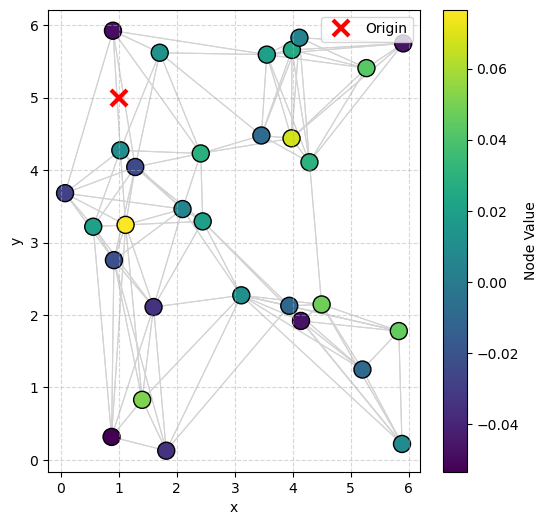

In [8]:
visualize_graph_torch(data, color='signal')

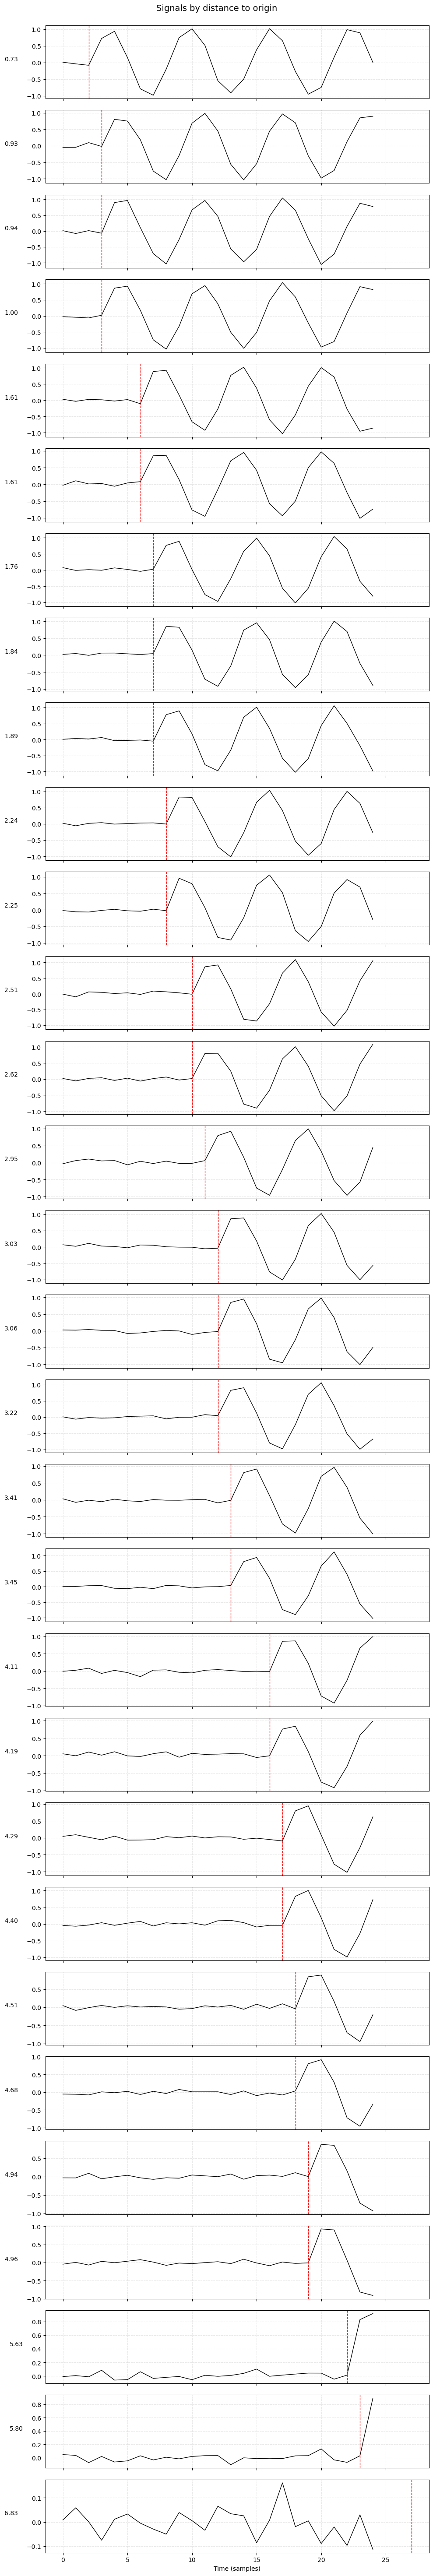

In [9]:
plot_signals_subplots_by_distance(data)

### 🧪 Train/Validation/Test Split and Batching

After generating the full synthetic dataset, we split it into three subsets:

- **80%** for training
- **10%** for validation
- **10%** for testing

We then use `torch_geometric.loader.DataLoader` to batch graphs during training and evaluation.

#### 🧱 How batching works in PyTorch Geometric:
- Nodes, edges, and features from multiple graphs are merged into a single "big graph."
- A `batch` vector tracks which nodes belong to which original graph.
- This enables efficient parallel processing across many small graphs in one forward pass.

We set a `batch_size=64` and shuffle only the training set to ensure randomness while preserving validation/test consistency.


In [10]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(dataset, train_size=0.8, random_state=42)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=0.5, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"nb graph train ds= {len(train_dataset)}, nb graph val ds= {len(val_dataset)}, nb graph test ds= {len(test_dataset)}")

nb graph train ds= 4000, nb graph val ds= 500, nb graph test ds= 500


## 🧠 GNN Model Definition: BasicNet

We define a Graph Neural Network (GNN) model designed for **node-level sine wave regression**.

### 🏗️ Architecture Overview:

1. **Signal Feature Extraction**  
   Each node’s raw signal is processed through a simple MLP to extract compact local features.

2. **Feature Fusion**  
   The extracted signal features are concatenated with the node's spatial coordinates (x, y) to create a combined feature vector.

3. **Graph Attention Message Passing**  
   We apply a `GATv2Conv` layer to propagate and aggregate information between neighboring nodes:
   - Attention mechanisms allow the model to learn which neighbors are most informative.
   - Edge weights based on spatial distances are provided as additional input.

4. **Multi-Layer Perceptron (MLP) Decoder**  
   After message passing, another MLP refines the hidden features and predicts the full sine wave signal at each node.

> 🔥 **Key Difference**:  
> Instead of predicting a single global coordinate, this model predicts a **full waveform per node**.

### 📤 Output:
- For each node, the model outputs a predicted sine wave of the same length as the true target signal.
- The output is bounded in the range **[-1, 1]** using a `tanh()` activation, consistent with sine wave values.


In [11]:
class BasicNet(torch.nn.Module):
    """
    A minimal Graph Neural Network for node-level signal reconstruction.

    Architecture:
    - MLP to fuse spatial coordinates and raw signal
    - Single GATv2Conv layer for graph message passing
    - MLP decoder to reconstruct the node signals
    """
    def __init__(self, channels_x, channels_y, hidden_channels=32, dropout=0.3):
        super(BasicNet, self).__init__()
        torch.manual_seed(1234)

        # --- Feature fusion ---
        self.mlp_in = MLP([channels_x + channels_y, hidden_channels])

        # --- Graph convolution ---
        self.conv = GATv2Conv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            heads=1,
            concat=True,
            edge_dim=2
        )
        self.conv2 = GATv2Conv(
            hidden_channels, 
            hidden_channels, 
            heads=1, 
            concat=True, 
            edge_dim=2
        )

        # --- Decoder ---
        self.mlp_out = MLP([hidden_channels, channels_y])

    def forward(self, x, signal, edge_index, edge_attr, mask):
        """
        Forward pass.

        Args:
            x (Tensor): Node features (e.g., spatial coordinates) [num_nodes, channels_x]
            signal (Tensor): Node signals (raw) [num_nodes, channels_y]
            edge_index (Tensor): Edge index for the graph
            edge_weight (Tensor): Edge weights
            mask (Tensor): Mask indicating supervised nodes

        Returns:
            Tensor: Reconstructed node signals [num_nodes, channels_y]
        """
        # Apply mask (simulate missing inputs)
        signal = (signal.T * (~mask)).T

        # --- Feature fusion ---
        out = torch.cat([x, signal], dim=-1)
        out = self.mlp_in(out)

        # --- Graph convolution ---
        out = self.conv(out, edge_index, edge_attr)
        out = self.conv2(out, edge_index, edge_attr)

        # --- Final decoding ---
        out = self.mlp_out(out)

        return out.tanh()

    @staticmethod
    def get_mask(graph_size: int, rate: float, device):
        """
        Randomly generate a node mask for supervision during training.
    
        Args:
            graph_size (int): Number of nodes in the graph.
            rate (float): Fraction of nodes to supervise (between 0 and 1).
            device: Target device (CPU or GPU).
    
        Returns:
            Tensor: A boolean mask indicating which nodes to supervise.
        """
        mask = torch.rand(graph_size, device=device) < rate
        return mask

## 🚀 Training Loop

This section defines the training and validation routines for our GNN model, as well as a simple early stopping mechanism.

### 🛠️ Training and Validation Helper Functions

Before launching training, we define helper functions to structure the training and validation process.

### ⏹️ Early Stopping: `EarlyStopper`
Early stopping monitors the **validation loss** to detect overfitting.  
It stops training when the model stops improving for a given number of epochs (`patience`).

This helps avoid:
- Wasting compute resources
- Overfitting to the training set

---

### 🛠️ Training Function: `train()`

For each batch of graphs:
1. **Dynamically generate a random mask** selecting a subset of nodes for supervision.
2. Perform a forward pass through the model **using the generated mask** (the mask modifies the input signals).
3. Compute the loss **only on the masked (supervised) nodes**.
4. Backpropagate and update model parameters.

> 🧠 **Why use a dynamic mask?**  
> - In node-level prediction, we don't want to supervise all nodes.
> - In this use case, the target is the input itself, so without masking, a node could trivially copy its input!
> - Dynamic masking ensures the model must infer missing signals by leveraging neighborhood information.
> - Different nodes are randomly selected in each batch, improving generalization.

The loss is computed **only** for the nodes selected by the dynamic mask.

---

### 🧪 Validation Function: `validation()`

During validation:
- We also **dynamically generate a new random mask** per batch.
- This ensures evaluation matches training conditions (masked input, selective supervision).
- Gradients are disabled using `@torch.no_grad()` for efficiency.

> ⚡ Note:  
> Message passing still uses the full graph (all nodes), but supervision happens **only on the masked nodes**!

---


In [12]:
class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.
    
    Parameters:
    -----------
    patience : int, optional (default=1)
        The number of epochs with no improvement in validation loss after which training will be stopped.
    min_delta : float, optional (default=0)
        The minimum change in the validation loss required to qualify as an improvement.
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
        Check if the training process should be stopped.
        
        Parameters:
        -----------
        validation_loss : float
            The current validation loss.
            
        Returns:
        --------
        stop : bool
            Whether the training process should be stopped or not.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    

def train(dataloader, device, mask_rate=0.1):
    """
    Train the model with dynamic masking per batch.

    Args:
        dataloader : DataLoader — training data.
        device : torch.device
        mask_rate : float — fraction of nodes supervised per graph.

    Returns:
        mean_loss : float — mean training loss across batches.
    """
    model.train()
    mean_loss = 0

    for batch in dataloader:
        batch = batch.to(device)

        # Generate dynamic supervision mask BEFORE forward pass
        mask = model.get_mask(batch.num_nodes, rate=mask_rate, device=device)

        # Forward pass using masked input
        out = model(batch.pos, batch.signal, batch.edge_index, batch.edge_attr, mask)

        # Compute loss only on supervised nodes
        loss = criterion(out[mask], batch.signal[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()

    return mean_loss / len(dataloader)


@torch.no_grad()
def validation(dataloader, device, mask_rate=0.1):
    """
    Validate the model with dynamic masking per batch.

    Args:
        dataloader : DataLoader — validation data.
        device : torch.device
        mask_rate : float — fraction of nodes supervised per graph.

    Returns:
        mean_loss : float — mean validation loss across batches.
    """
    model.eval()
    mean_loss = 0

    for batch in dataloader:
        batch = batch.to(device)

        # 🔥 Generate dynamic supervision mask BEFORE forward pass
        mask = model.get_mask(batch.num_nodes, rate=mask_rate, device=device)

        # Forward pass using masked input
        out = model(batch.pos, batch.signal, batch.edge_index, batch.edge_attr, mask)

        # Compute loss only on supervised nodes
        loss = criterion(out[mask], batch.signal[mask])

        mean_loss += loss.item()

    return mean_loss / len(dataloader)

### ⚙️ Training Setup

We now configure the components needed to train the model:

- **Device Selection**  
  Automatically use GPU (`cuda:0`) if available; otherwise fall back to CPU.

- **Model Instantiation**  
  Initialize the `BasicNet` model with:
  - Positional feature size (`data.pos.shape[1]`)
  - Signal feature size (`data.signal.shape[1]`)
  - Hidden channels set to 64.

- **Loss Function**  
  We use **Mean Squared Error (MSELoss)** because the task is a regression problem (predicting continuous sine waves).

- **Optimizer**  
  **Adam optimizer** is used for its efficiency and robustness in training deep models.

- **Early Stopping**  
  An `EarlyStopper` is set up with:
  - `patience=10` (number of epochs without improvement before stopping)
  - `min_delta=0.0` (smallest improvement to be considered progress)

- **Training State Variables**  
  - `loss_train` and `loss_val` store the loss history.
  - `best_loss` tracks the best validation loss seen so far.
  - `PATH_CHECKPOINT` defines where to save the best model weights.

---


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


model = BasicNet(data.pos.shape[1], data.signal.shape[1], hidden_channels=256).to(device)

criterion = torch.nn.MSELoss()  # Define loss criterion.
# criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define optimizer.
early_stopper = EarlyStopper(patience=10, min_delta=0.0)
loss_train = []
loss_val = []
best_loss = 1
best_epoch = 0
PATH_CHECKPOINT = "./checkpoint/best_masked.pt"
# Create the folder if it doesn't exist
os.makedirs(os.path.dirname(PATH_CHECKPOINT), exist_ok=True)
mask_rate = 0.3
model

BasicNet(
  (mlp_in): MLP(27, 256)
  (conv): GATv2Conv(256, 256, heads=1)
  (conv2): GATv2Conv(256, 256, heads=1)
  (mlp_out): MLP(256, 25)
)

### 🔁 Training Loop

We now launch the model training:

- Loop over a maximum of **5000 epochs**.
- For each epoch:
  1. Perform a full pass over the training data and compute the mean training loss.
  2. Perform a full pass over the validation data and compute the mean validation loss.
  3. Update the training progress bar with the latest losses.
  4. If the validation loss improves, save the model checkpoint.
  5. If early stopping criteria are met, stop training early.

### 📈 Monitoring:
- We use `tqdm` to display a live progress bar with the latest training and validation loss.
- The **best model** (lowest validation loss) is saved automatically to `PATH_CHECKPOINT`.

> 🧠 **Reminder:**  
> Dynamic masking is used both during training and validation, so different nodes are randomly supervised in every batch.

### 🧠 Input Masking Strategy: Preventing Cheating

Unlike typical label masking or partial supervision,  
**we use masking to deliberately corrupt node inputs** during training.

- For each training node, its **own input signal is zeroed out**.
- The model **cannot access its own signal** directly.
- It must **reconstruct the missing signal** using **only its neighbors** via message passing.

✅ All nodes still participate fully in the graph structure.  
✅ Only the input features of supervised nodes are masked.

---

**Training flow:**
1. Full graph is built.
2. Input signal of supervised nodes is zeroed out.
3. Message passing happens across the entire graph.
4. Loss is computed **only** at the masked (supervised) nodes.
5. Gradients update the model to better reconstruct missing signals.

---

> 🧠 **This approach forces the GNN to learn meaningful spatial patterns**,  
> and mimics real-world situations like seismic networks, GNSS, or sensor fields,  
> where some stations may be missing data and need to interpolate intelligently.

---

In [14]:
start_time = time.perf_counter()

nb_epoch = tqdm(range(5000))

for epoch in nb_epoch:
    loss_train.append(train(train_loader, device, mask_rate))
    loss_val.append(validation(val_loader, device, mask_rate))
    
    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"early stopping at epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}")
        break
    nb_epoch.set_postfix_str(f"train loss={loss_train[-1]}, val loss={loss_val[-1]}")

  2%|▏         | 80/5000 [10:25<10:41:03,  7.82s/it, train loss=0.1465812228501789, val loss=0.14879522658884525] 


KeyboardInterrupt: 

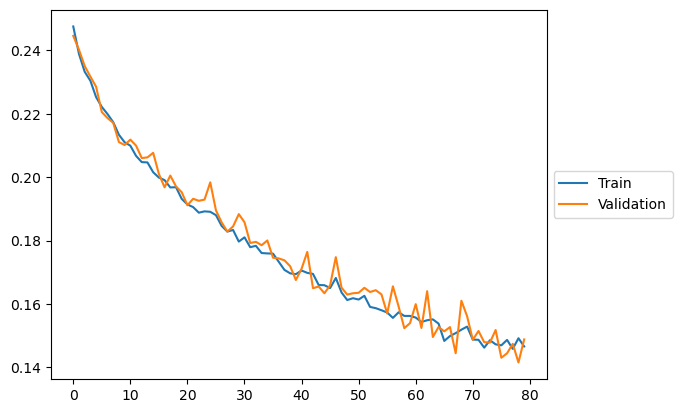

In [15]:
plt.plot(loss_train, label="Train")
plt.plot(loss_val, label = "Validation")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 🧪 Model Evaluation

After training, we evaluate the model’s performance on the test set.

### 🎯 Evaluation Goals:
- Measure how well the model can **predict the full sine wave at each node**.
- Assess overall performance with **quantitative metrics** (like Mean Absolute Error).
- **Visualize** individual predictions to qualitatively inspect model behavior.

### 🚦 Key Differences from Training:
- **No dynamic masking during evaluation**:  
  - We want to predict the full signal at every node, not just a subset.
  - A mask of all `False` values is passed to the model to disable input corruption.
- **Full supervision**:  
  - The loss and metrics are computed across **all nodes** without random sampling.

### 📊 Evaluation Metrics:
- **Mean Absolute Error (MAE)**:  
  Measures the average absolute difference between predicted and true signals at each node.
- **Histogram of per-node errors**:  
  Helps understand the distribution of prediction errors across the entire test set.
- **Qualitative plots**:  
  Overlay predicted and true sine waves for random sample nodes to visually inspect performance.

> 🧠 **Reminder:**  
> Even though the model was trained with incomplete (masked) signals, during evaluation we test its ability to recover the entire signal at every node.

---

In [16]:
# restore best model
PATH_CHECKPOINT = "./checkpoint/best_masked.pt"
model.load_state_dict(torch.load(PATH_CHECKPOINT))
print(f"best loss={best_loss}, model eval loss={validation(val_loader, device, mask_rate)} at epoch {best_epoch}")

best loss=0.14153017103672028, model eval loss=0.1522007416933775 at epoch 78


### 🛠️ Evaluation Function

We define an `evaluate()` function to test the model’s performance on the full test set.

Key differences compared to training:
- **No dynamic masking**:  
  We pass a "no mask" (all `False`) tensor to the model. This ensures **full input signals** are used for prediction.
- **Full node supervision**:  
  The loss and metrics are computed across **all nodes**, not just a random subset.

### 📋 Function Behavior:
- Perform a forward pass through the model for each batch in the test set.
- Compute the **Mean Absolute Error (MAE)** for each batch.
- Stack all predicted signals and ground truth signals for further visualization.

### 📤 Function Outputs:
- **`mean_mae`**: Average Mean Absolute Error across all nodes in the test set.
- **`pred_all`**: Stacked predictions for all nodes.
- **`true_all`**: Stacked ground truth sine waves for all nodes.

> 🧠 **Reminder:**  
> Evaluating on full signals allows us to truly assess how well the model reconstructs complete sine waves at each node.


In [17]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    """
    Evaluate the model on the full test set without dynamic masking.

    Args:
        model : Trained model
        dataloader : DataLoader for the test set
        device : torch.device

    Returns:
        mean_mae : float — Mean Absolute Error across all nodes
        pred_all : Tensor — Predicted signals (stacked) [num_nodes, signal_size]
        true_all : Tensor — Ground truth signals (stacked) [num_nodes, signal_size]
    """
    model.eval()
    total_mae = 0
    pred_all = []
    true_all = []

    for batch in dataloader:
        batch = batch.to(device)

        # Create a zero mask → No input corruption during final evaluation
        no_mask = torch.zeros(batch.num_nodes, dtype=torch.bool, device=device)

        # Forward pass
        out = model(batch.pos, batch.signal, batch.edge_index, batch.edge_weight, no_mask)

        # Accumulate outputs
        pred_all.append(out.cpu())
        true_all.append(batch.signal.cpu())

        # Calculate MAE for the batch
        batch_mae = torch.mean(torch.abs(out - batch.signal))
        total_mae += batch_mae.item()

    # Aggregate
    mean_mae = total_mae / len(dataloader)
    pred_all = torch.cat(pred_all, dim=0)
    true_all = torch.cat(true_all, dim=0)

    return mean_mae, pred_all, true_all


### 🔍 Prediction and Visualization

After evaluating the model numerically, it is crucial to **visualize** how well it is reconstructing the node-level sine waves.

We perform two types of visual inspections:

---

### 🎯 1. Random Node Signal Comparison

- Randomly select a few nodes from the test set.
- Plot both the **true sine wave** and the **predicted sine wave** for each node.
- This helps us visually inspect how well the model captures the correct waveform shapes.

> 🧠 **Note:**  
> Perfect predictions would show overlapping dashed (true) and solid (predicted) lines.

---

### 📊 2. Histogram of Node Prediction Errors

- Compute the **L2 norm** (Euclidean distance) between the predicted and true signals at each node.
- Plot a histogram showing the distribution of node-wise errors across the entire test set.

This helps answer questions like:
- Are most predictions very close?
- Are there occasional large errors (outliers)?

> 🚦 **Goal:**  
> Ideally, the histogram is **skewed toward small errors**, indicating most nodes are well predicted!

---


In [18]:
# --- Predict and gather outputs ---
mean_mae, pred_all, true_all = evaluate(model, test_loader, device)

print(f"Mean Absolute Error (MAE) on Test Set: {mean_mae:.4f}")

Mean Absolute Error (MAE) on Test Set: 0.3541


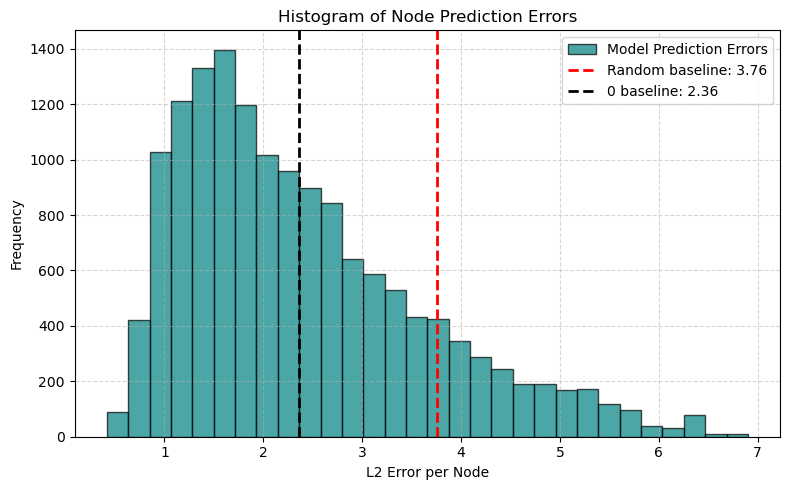

In [19]:
# --- Compute per-node L2 errors ---
node_errors = torch.norm(pred_all - true_all, dim=1).numpy()

# --- Estimate random prediction baseline ---
# Random predictions between -1 and 1 (since tanh activation output is bounded)
rand_preds = 2 * torch.rand_like(true_all) - 1  # Uniform random between [-1, 1]
rand_errors = torch.norm(rand_preds - true_all, dim=1).numpy()
expected_random_error = rand_errors.mean()

pred_0 = torch.zeros(true_all.shape)
pred_0_errors = torch.norm(pred_0 - true_all, dim=1).numpy()
expected_pred_0_error = pred_0_errors.mean()

# --- Plot
plt.figure(figsize=(8, 5))
plt.hist(node_errors, bins=30, alpha=0.7, color='teal', edgecolor='black', label="Model Prediction Errors")
plt.axvline(expected_random_error, color="red", linestyle="--", linewidth=2, label=f"Random baseline: {expected_random_error:.2f}")
plt.axvline(expected_pred_0_error, color="black", linestyle="--", linewidth=2, label=f"0 baseline: {expected_pred_0_error:.2f}")

plt.xlabel("L2 Error per Node")
plt.ylabel("Frequency")
plt.title("Histogram of Node Prediction Errors")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

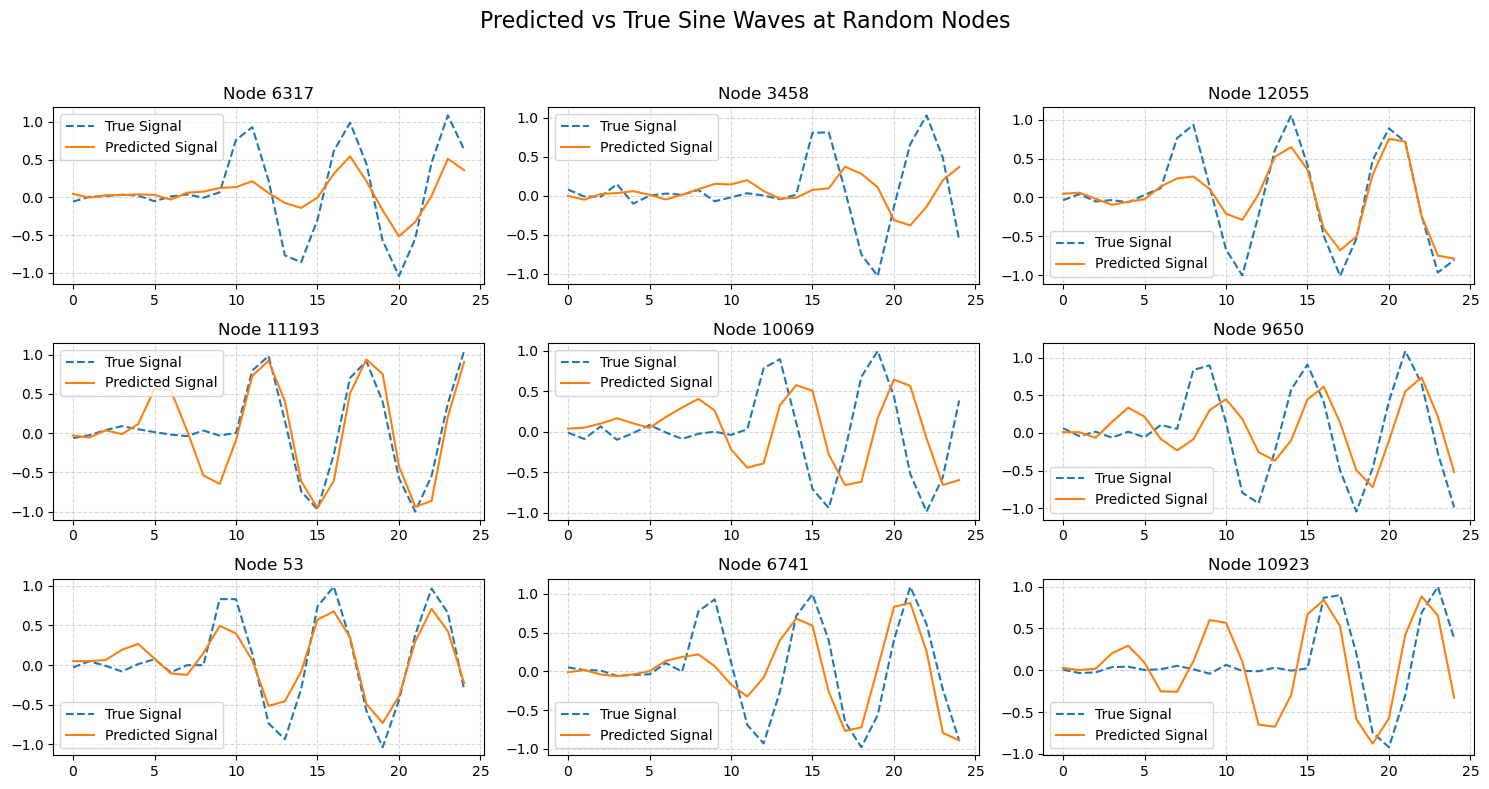

In [20]:
# --- Pick random nodes ---
num_samples = 9
random_indices = random.sample(range(pred_all.shape[0]), num_samples)

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
axs = axs.flatten()

for i, idx in enumerate(random_indices):
    axs[i].plot(true_all[idx].numpy(), label="True Signal", linestyle='--')
    axs[i].plot(pred_all[idx].numpy(), label="Predicted Signal", linestyle='-')
    axs[i].set_title(f"Node {idx}")
    axs[i].legend()
    axs[i].grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Predicted vs True Sine Waves at Random Nodes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 🌐 Spatial Visualization of Node Errors

To better understand where the model performs well (or poorly),  
we visualize the spatial distribution of node-level errors across multiple random test graphs.

For each selected graph:
- **Nodes** are colored according to their **Mean Absolute Error (MAE)** between predicted and true signals.
- **Edges** are shown in light gray to illustrate graph connectivity.
- A colorbar indicates the magnitude of error at each node.

### 🧠 Interpretation:
- Lower-error nodes (dark blue) suggest the model can accurately reconstruct the signal.
- Higher-error nodes (yellow/green) highlight more challenging areas.
- By comparing graphs, we can investigate if node **density** and **connectivity** correlate with prediction quality.

> 🔍 **Hypothesis:**  
> Nodes in densely connected areas should have lower errors, as the model can better leverage neighbor information.

---


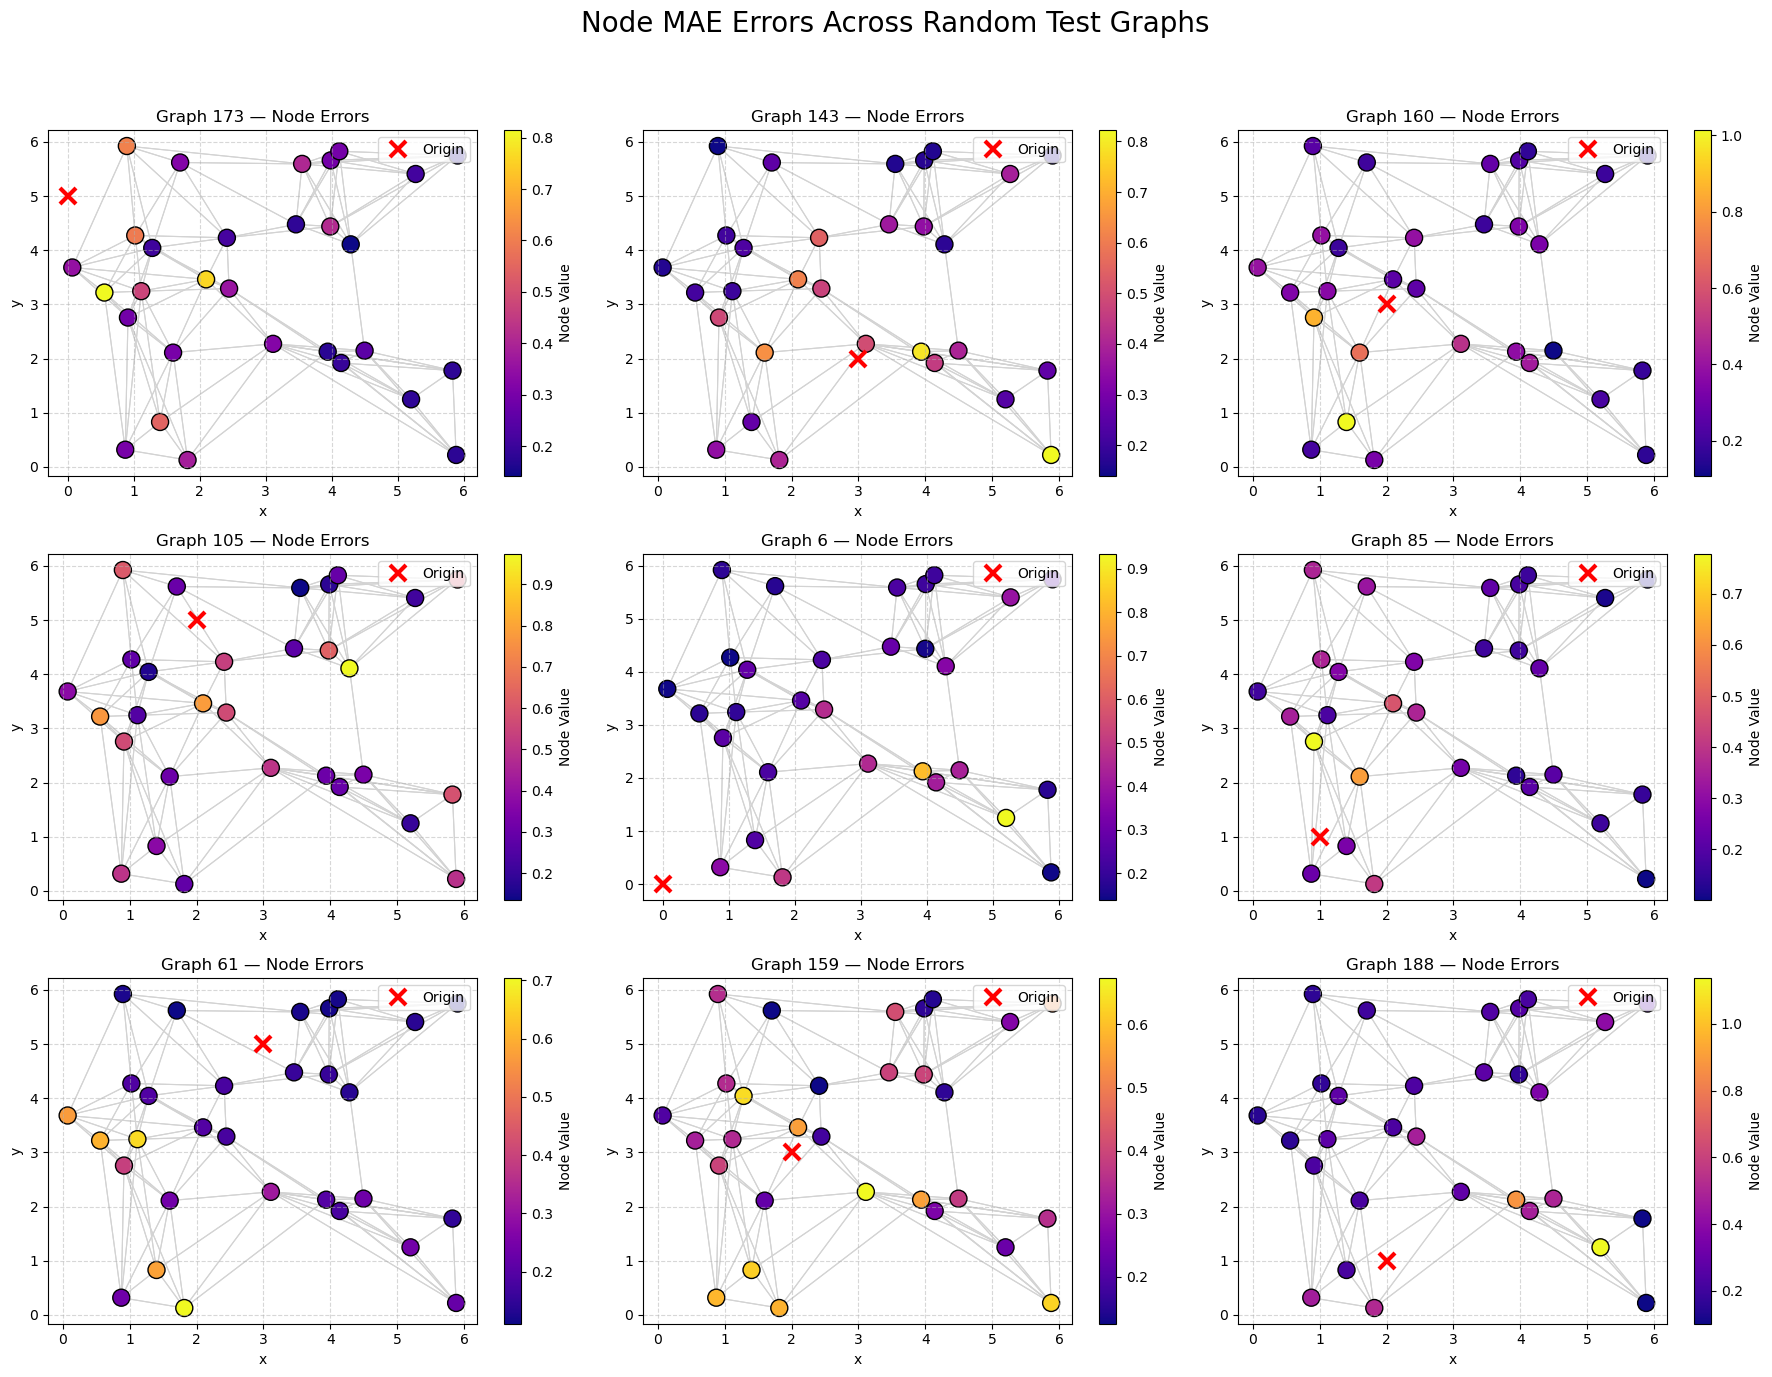

In [21]:
# --- Sample 9 graphs randomly ---
sample_graph_indices = random.sample(range(len(test_dataset)), 9)

fig, axs = plt.subplots(3, 3, figsize=(18, 14))
axs = axs.flatten()

node_pointer = 0

for i, graph_idx in enumerate(sample_graph_indices):
    g = test_dataset[graph_idx]
    num_nodes = g.pos.shape[0]

    # Extract predictions and truths for this graph
    preds = pred_all[node_pointer:node_pointer + num_nodes]
    trues = true_all[node_pointer:node_pointer + num_nodes]

    # Compute per-node MAE
    node_errors = torch.mean(torch.abs(preds - trues), dim=1).numpy()

    # --- Use the new helper to plot into specific axis
    visualize_graph_torch(
        g,
        node_values=node_errors,
        cmap="plasma",
        ax=axs[i],
        title=f"Graph {graph_idx} — Node Errors"
    )

    node_pointer += num_nodes

# Hide any unused subplots (shouldn't happen since we picked exactly 9)
for j in range(len(sample_graph_indices), len(axs)):
    axs[j].axis('off')

plt.suptitle("Node MAE Errors Across Random Test Graphs", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 🏁 Conclusion

In this notebook, we built and trained a Graph Neural Network (GNN) model for **node-level sine wave reconstruction**.  
We covered the full workflow:

- 🛠️ Built a synthetic dataset with sine wave signals delayed by spatial distance.
- 🧠 Designed a custom GNN model (`BasicNet`) combining signal feature extraction and attention-based message passing.
- 🎯 Trained the model using **dynamic masking** to simulate incomplete input signals.
- 📈 Monitored training with early stopping and validation loss tracking.
- 🧪 Evaluated performance using:
  - Mean Absolute Error (MAE)
  - True vs Predicted signal plots
  - Histogram of node prediction errors
  - Spatial visualizations of node-level errors across graphs

---

### 🚀 Key Takeaways:
- GNNs can effectively reconstruct node-level signals even when only partial inputs are available.
- Dense graphs (with strong neighbor connectivity) generally lead to better local predictions.
- Visualization tools are crucial for both debugging and interpreting GNN behavior.

---

### 🔮 Possible Extensions:
- Test deeper GNN architectures (e.g., stacking multiple GATv2 layers).
- Enrich edge features (e.g., relative positions, arrival time differences).
- Experiment with different dynamic masking rates during training.
- Explore more realistic datasets where node features evolve over time.

---

### 📚 Want to see GNNs applied to real geophysical data?
If you're interested in how Graph Neural Networks can be used beyond synthetic examples,  
check out our recent work applying GNNs to **denoise real daily GNSS time series** in the Cascadia subduction zone:

> **Bachelot, L., Thomas, A. M., Melgar, D., Searcy, J., & Sun, Y.-S. (2025).**  
> *Cascadia Daily GNSS Time Series Denoising: Graph Neural Network and Stack Filtering.*  
> Seismica, 2(4). [https://doi.org/10.26443/seismica.v2i4.1419](https://doi.org/10.26443/seismica.v2i4.1419)

---
